# 🔍 Détection d'Anomalies Zero-Shot avec CLIP

**Auteur :** KOUYATE Yannis
**Contexte :** Contrôle Qualité Industriel

Ce notebook démontre comment utiliser des **Modèles de Fondation Vision-Langage (CLIP)** pour détecter des défauts sur des objets sans aucun entraînement préalable (*Zero-Shot*). [cite_start]Cette approche résout le problème du manque de données d'anomalies dans l'industrie[cite: 5, 10, 20].

**Méthodologie :**
1.  Encodage de l'image de test.
2.  Création de "Prompts" textuels décrivant l'état normal et anormal.
3.  Calcul de la similarité sémantique (Produit Scalaire) pour classifier l'image.

In [1]:
# Installation silencieuse des dépendances si lancée sur Google Colab
!pip install git+https://github.com/openai/CLIP.git -q

import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Configuration du Device (MPS pour Mac, CUDA pour Nvidia, CPU sinon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"✅ Device utilisé : {device}")

# Chargement du modèle CLIP (ViT-B/16 est un standard robuste)
model, preprocess = clip.load("ViT-B/16", device=device)
model.eval() # Mode évaluation (pas d'entraînement)
print("✅ Modèle CLIP chargé avec succès.")

✅ Device utilisé : mps


100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 46.6MiB/s]


✅ Modèle CLIP chargé avec succès.


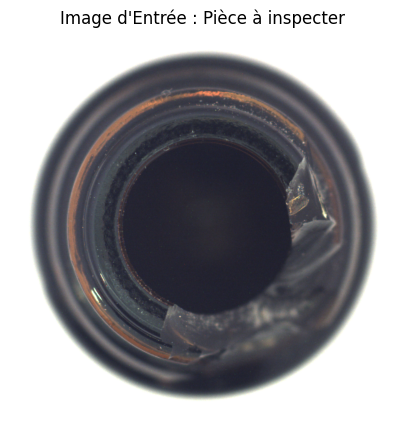

Dimension du tenseur image : torch.Size([1, 3, 224, 224])


In [2]:
# Chemin vers l'image exemple (assurez-vous que le fichier existe)
image_path = "assets/bottle_test.png"

try:
    # 1. Chargement visuel pour l'affichage
    original_image = Image.open(image_path).convert("RGB")
    
    # 2. Prétraitement pour le modèle (Redimensionnement, Normalisation)
    image_input = preprocess(original_image).unsqueeze(0).to(device)
    
    # Affichage
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.title("Image d'Entrée : Pièce à inspecter")
    plt.axis("off")
    plt.show()
    print(f"Dimension du tenseur image : {image_input.shape}")

except FileNotFoundError:
    print("❌ Erreur : L'image 'assets/bottle_test.png' est introuvable. Vérifiez le chemin.")

In [3]:
# Nous définissons ici les "classes" que le modèle doit chercher.
# [cite_start]L'astuce est d'utiliser plusieurs descriptions pour être plus robuste (Prompt Ensembling)[cite: 41].

prompts = {
    "Normal": [
        "a photo of a perfect bottle",
        "a bottle without defect",
        "a flawless object"
    ],
    "Anomalie": [
        "a photo of a broken bottle",
        "a bottle with cracks",
        "a damaged bottle",
        "a bottle with scratches"
    ]
}

# Fonction pour encoder le texte
def encode_text(prompts_list):
    text_tokens = clip.tokenize(prompts_list).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True) # Normalisation
    return text_features.mean(dim=0, keepdim=True) # Moyenne des prompts (Ensembling)

# Création des embeddings de référence
embedding_normal = encode_text(prompts["Normal"])
embedding_anomaly = encode_text(prompts["Anomalie"])

# Concaténation pour la classification
text_features = torch.cat([embedding_normal, embedding_anomaly])
print("✅ Embeddings textuels générés.")

✅ Embeddings textuels générés.


In [4]:
with torch.no_grad():
    # Encodage de l'image
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # Calcul de similarité (Produit Scalaire)
    # Plus le score est haut, plus l'image ressemble au texte
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(2)

# Interprétation
probs = similarity[0].cpu().numpy()
labels = ["Normal", "Anomalie"]

print(f"\n📊 RÉSULTATS DE L'ANALYSE :")
print("-" * 30)
for i, label in enumerate(labels):
    print(f"{label:10s} : {probs[i]*100:.2f}%")
print("-" * 30)

if probs[1] > probs[0]:
    print("🔴 DÉFAUT DÉTECTÉ ! L'objet est considéré comme anormal.")
else:
    print("🟢 CONFORME. Aucune anomalie détectée.")


📊 RÉSULTATS DE L'ANALYSE :
------------------------------
Normal     : 0.51%
Anomalie   : 99.50%
------------------------------
🔴 DÉFAUT DÉTECTÉ ! L'objet est considéré comme anormal.
